In [ ]:
from pathlib import Path
import pandas as pd

project_folder = Path.home() / 'Documents' / 'TFG'
data_folder = project_folder / 'data_folder'

# Carreguem l'arxiu CSV
csv_path = data_folder / 'HAM10000_metadata'
df = pd.read_csv(csv_path)

# Comprobem les primeres files
print(df.head())

     lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3  vidir_modern  
4  vidir_modern  


In [17]:
df = df.drop(columns=['dx_type', 'age', 'sex', 'localization', 'dataset'])
print(df.head())

     lesion_id      image_id   dx
0  HAM_0000118  ISIC_0027419  bkl
1  HAM_0000118  ISIC_0025030  bkl
2  HAM_0002730  ISIC_0026769  bkl
3  HAM_0002730  ISIC_0025661  bkl
4  HAM_0001466  ISIC_0031633  bkl


In [18]:
# Comprobem la distribució de les classes
print("Distribució de les classes:\n", df["dx"].value_counts(normalize=True))


Distribució de les classes:
 dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: proportion, dtype: float64


In [19]:
# Comprobem el nombre de classes úniques
classes = df['dx'].unique()
print(classes)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


In [20]:
# Comprobem el nombre d'observacions per classe
total_class_counts = df['dx'].value_counts()
print(total_class_counts)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [ ]:
# Es conta el nombre d'images que hi ha per classe
image_counts = df['lesion_id'].value_counts()

# Es creen dos data frames: df_train y df_val
# Com que existeixen pacients amb més d'una imatge aquestes aniran tots a df_train
df_train = df[df['lesion_id'].isin(image_counts[image_counts > 1].index)]

# A df_val aniran, de moment, la resta d'imatges
df_val = df[df['lesion_id'].isin(image_counts[image_counts == 1].index)]

# Es verifiquen les divisiones
print(f"df_train te {len(df_train)} registres")
print(f"df_val te {len(df_val)} registres")

df_train te 4501 registros
df_val te 5514 registros


In [ ]:
classes = df['dx'].unique()
total_class_counts = df['dx'].value_counts()
train_class_counts = df_train['dx'].value_counts()

# S'itera sobre totes les classes
for cls in classes:
	# Es calcula el nombre d'imatges que falten per completar el 80% dessitjat al train dataset
	missing = int(total_class_counts[cls] * 0.8 - train_class_counts[cls])
	# print(cls, ": Missing ", missing, "images to complete")

	if missing > 0:
		# Es filtren les imatges que perteneixen a la clase a df_val
		temp_class_df = df_val[df_val['dx'] == cls]

		# Si hi ha suficients imatges a df_val per completar el 80% a df_train
		if len(temp_class_df) >= missing:
			# Es seleccionen aleatoriament el nombre d'imatges calculades de df_val per moureles a df_train
			selected_images = temp_class_df.sample(n=missing, random_state=42)

			# S'afegeixen les imatges al conjunt d'entrenament i s'eliminen del conjunt de validació
			df_train = pd.concat([df_train, selected_images])
			df_val = df_val.drop(selected_images.index)
		else:
			print(f"No hi ha suficients imatges per a completar la classe {cls}. Es necessiten: {missing}, disponibles: {len(temp_class_df)}")

# Ara df_train conté el 80% de les imatges de cada clase, i df_val el 20% restant.
print("Distribució de classes de df_train:\n", df_train["dx"].value_counts(normalize=True))
print("Distribució de classes de df_val:\n", df_val["dx"].value_counts(normalize=True))

Distribució de classes de df_train:
 dx
nv       0.669663
mel      0.111111
bkl      0.109738
bcc      0.051311
akiec    0.032584
vasc     0.014107
df       0.011486
Name: proportion, dtype: float64
Distribució de classes de df_val:
 dx
nv       0.668828
mel      0.111222
bkl      0.109726
bcc      0.051372
akiec    0.032918
vasc     0.014464
df       0.011471
Name: proportion, dtype: float64


In [23]:
print(f"df_train te {len(df_train)} registres")
print(f"df_val te {len(df_val)} registres")

df_train te 8010 registres
df_val te 2005 registres


In [ ]:
# S'esborren les columnes no necessaries
df = df.drop(columns=['lesion_id'])
df_train = df_train.drop(columns=['lesion_id'])
df_train = df_train.reset_index(drop=True)
df_val = df_val.drop(columns=['lesion_id'])
df_val = df_val.reset_index(drop=True)

print(df_train.head())

       image_id   dx
0  ISIC_0027419  bkl
1  ISIC_0025030  bkl
2  ISIC_0026769  bkl
3  ISIC_0025661  bkl
4  ISIC_0031633  bkl


In [ ]:
# Es crear un diccionari que asigna un valor numèric a cada classe de lesió
class_to_int = {'background': 0 }
for i, cls in enumerate(classes):
	class_to_int[cls] = i + 1

print(class_to_int)

{'background': 0, 'bkl': 1, 'nv': 2, 'df': 3, 'mel': 4, 'vasc': 5, 'bcc': 6, 'akiec': 7}


In [26]:
int_to_class = {v: k for k, v in class_to_int.items()}

print(int_to_class)


{0: 'background', 1: 'bkl', 2: 'nv', 3: 'df', 4: 'mel', 5: 'vasc', 6: 'bcc', 7: 'akiec'}


In [ ]:
# Es guarden els data frames i els diccionaris
import pickle

data_to_save = {
    "classes": classes,
    "class_to_int": class_to_int,
    "int_to_class": int_to_class,
    "df": df,
    "df_train": df_train,
    "df_val": df_val
}

with open(data_folder / "dataset_info.pkl", "wb") as f:
    pickle.dump(data_to_save, f)

# df.to_pickle(data / 'df.pkl')
# df_train.to_pickle(data / 'df_train.pkl')
# df_val.to_pickle(data / 'df_val.pkl')

In [ ]:
# Es conveteixen les màscares binàries a màscares semàntiques

import os
from PIL import Image
import numpy as np

masks_folder = data_folder / 'binary_segmentations'
destination_folder = data_folder / 'semantic_segmentations'
# Es crea la carpeta de sortida si no existeis
os.makedirs(destination_folder, exist_ok=True)

for _, row in df.iterrows():
	# S'obté el nom de la imatge y la clase (dx)
	image_id = row['image_id']
	dx = row['dx']

	# S'obté el valor de la clase segons el dx
	class_value = class_to_int.get(dx)

	# Es carrega la mascara binària
	mask_path = masks_folder / f'{image_id}_segmentation.png'
	try:
		mask_image = Image.open(mask_path)
		mask_array = np.array(mask_image)

		# Es canvien els pixels amb valor 255 pel valor de la clase
		mask_array[mask_array == 255] = class_value

		new_mask_image = Image.fromarray(mask_array.astype(np.uint8))

		# Es guarda la nova mascara a la carpeta 'semantic_segmentations'
		new_mask_path = destination_folder / f'{image_id}.png'
		new_mask_image.save(new_mask_path)


	except Exception as e:
		print(f"No s'ha pogut processar la imatge {image_id}: {e}")

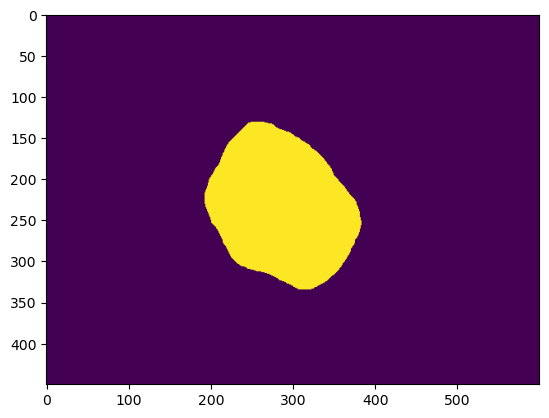

In [ ]:
# Es visualitza un màscara aleatòria
import matplotlib.pyplot as plt

row = df.sample().iloc[0]
image_id = row['image_id']
dx = row['dx']

class_value = class_to_int.get(dx)


try:
	mask_path = destination_folder / f'{image_id}.png'
	mask_image = Image.open(mask_path)
	mask_array = np.array(mask_image)

	plt.imshow(mask_image)

except Exception as e:
	print(f"No se pudo procesar la imagen {image_id}: {e}")

In [ ]:
# Es comprova l'integritat de les dades guardades
with open(data_folder / "dataset_info.pkl", "rb") as f:
    data_loaded = pickle.load(f)

classes = data_loaded["classes"]
class_to_int = data_loaded["class_to_int"]
int_to_class = data_loaded["int_to_class"]
df = data_loaded["df"]
df_train = data_loaded["df_train"]
df_val = data_loaded["df_val"]


In [25]:
classes
class_to_int
int_to_class
df
df_train

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
9766,ISIC_0028854,akiec
9931,ISIC_0024329,akiec
9756,ISIC_0029541,akiec
9948,ISIC_0027562,akiec
